In [14]:
#import libraries
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
pip install wordcloud

  Using cached wordcloud-1.8.1.tar.gz (220 kB)
Using legacy 'setup.py install' for wordcloud, since package 'wheel' is not installed.
    Running setup.py install for wordcloud ... done
Note: you may need to restart the kernel to use updated packages.


In [15]:
appName="Collaborative Filtering with PySpark"

#initialize the spark session
spark = SparkSession.builder.appName(appName).getOrCreate()

#get sparkcontext from the sparksession
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [16]:
df_business = sqlContext.read.json('ratings.json')
df_review = sqlContext.read.json('review.json')

In [49]:
df_business_.show(10)

+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|           city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|     10913 Bailey Rd|{null, null, null...|f9NumwFMBDn751xgF...|Active Life, Gun/...|      Cornelius|{11:0-20:0, 10:0-...|      1|   35.4627242|   -80.8526119|The Range At Lake...|      28031|          36|  3.5|   NC|
|8880 E Via Linda,...|{null, null, null...|Yzvjg0SayhoZgCljU...|Health & Medical,...|     Scottsdale|                null|      

In [50]:
df_review_.show(10)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|-MhfebM0QIsKt87iD...|   0|2015-04-15 05:21:16|    0|xQY8N_XvtGbearJ5X...|  2.0|As someone who ha...|     5|OwjRMXRC0KyPrIlcj...|
|lbrU8StCq3yDfr-QM...|   0|2013-12-07 03:16:52|    1|UmFMZ8PyXZTY2Qcwz...|  1.0|I am actually hor...|     1|nIJD_7ZXHq-FX8byP...|
|HQl28KMwrEKHqhFrr...|   0|2015-12-05 03:18:11|    0|LG2ZaYiOgpr2DK_90...|  5.0|I love Deagan's. ...|     1|V34qejxNsCbcgD8C0...|
|5JxlZaqCnk1MnbgRi...|   0|2011-05-27 05:30:52|    0|i6g_oA9Yf9Y31qt0w...|  1.0|Dismal, lukewarm,...|     0|ofKDkJKXSKZXu5xJN...|
|IS4cv902ykd8wj1TR...|   0|2017-01-14 21:56:57|    0|6TdNDKywdbjoTkize...|  4.0|Oh happy d

In [18]:
#Filter Rows and columns
#used inner join
city=Toronto
df_business = df_business.select("business_id","name", "stars", 
                                 "review_count", "attributes", 
                                 "categories", "city").withColumnRenamed("stars", "stars_restaurant")

df_business = df_business.filter((df_business['city'] == city) & (df_business.categories.contains('Restaurants'))).drop('city')

In [19]:
df_review = df_review.join(df_business, on='business_id', how='inner')

In [20]:
df_review.select(['business_id', 'user_id', 'stars']).show()

+--------------------+--------------------+-----+
|         business_id|             user_id|stars|
+--------------------+--------------------+-----+
|qUWqjjjfpB2-4P3He...|TZQSUDDcA4ek5gBd6...|  4.0|
|9Eghhu_LzEJgDKNgi...|iFEM16O5BeKvf_AHs...|  3.0|
|cDoo0Pf1d_P79Rq3Z...|1kNsEAhGU8d8xugMu...|  3.0|
|4m_hApwQ054v3ue_O...|Eg_VTAQwK3CxYTORN...|  5.0|
|jM6JjZXFAQQANwdlE...|IIE2OX5haarGNefY2...|  5.0|
|PMPMHHLe9vFzcR67i...|RRhco4irDXPk5EJmv...|  5.0|
|IfUkm42SB9D0m_Zbk...|Kl6jNDAE7PG_VVQaf...|  4.0|
|NrJSy3dgcXErFtOKG...|is1nHZ4oBqqmBm_mf...|  4.0|
|nY2oBwH3s5sKox1mE...|JnPIjvC0cmooNDfsa...|  5.0|
|tWdp26XQEJqJGnRmF...|IeojscL3rg3x3vtmR...|  4.0|
|tJcpzXzykNSLuzWwa...|6WmMHMBM4FLGyK98-...|  1.0|
|PjtX-5vSTBVyWfMRE...|pMefTWo6gMdx8WhYS...|  4.0|
|28adZ4lsuUeVB2aWz...|BwwqlPVsJk1dbUyNw...|  5.0|
|tvYID0arhN-shKGUr...|kmOvnwtroMBC8y9lO...|  1.0|
|sSdHUsUZ4mvkb5ymI...|0aHFybE0id9DD97Qz...|  4.0|
|n-5dPbGyziS0SOkVD...|Fw8Lj7q7DqTh-m3hG...|  4.0|
|0a1BBSewiusfCalA9...|hYnq9-wO-RzmiTTGM...|  4.0|


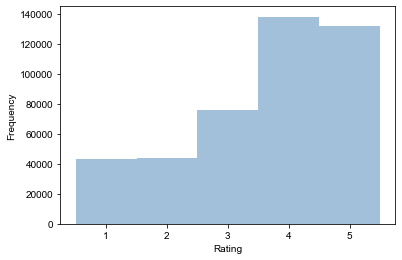

In [21]:
#convert the data from dataframe (pyspark) to pandas for visualisation
reviews = df_review.select('stars').collect()
review_list = [reviews[i][0] for i in range(len(reviews))]

plt.hist(review_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

In [ ]:
#generous public from Toronto as most ratings are above 3

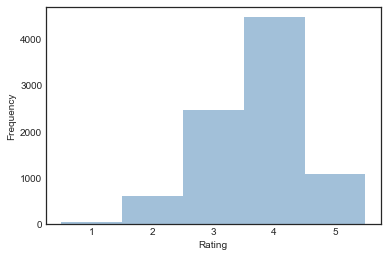

In [22]:
#distribution of ratings of each restaurant
restaurant_reviews = df_business.select('stars_restaurant').collect()
restaurant_reviews_list = [restaurant_reviews[i][0] for i in range(len(restaurant_reviews))]


plt.hist(restaurant_reviews_list, bins=[0.5,1.5,2.5,3.5,4.5,5.5], alpha=0.5,
         histtype='stepfilled', color='steelblue',
         edgecolor='none')
plt.ylabel('Frequency')
plt.xlabel('Rating')
plt.style.use('seaborn-white')

In [23]:
restaurant_categories = df_business.select('categories').collect()
restaurant_categories_list = [restaurant_categories[i][0] for i in range(len(restaurant_categories))]

In [24]:
text = " ".join(review for review in restaurant_categories_list)

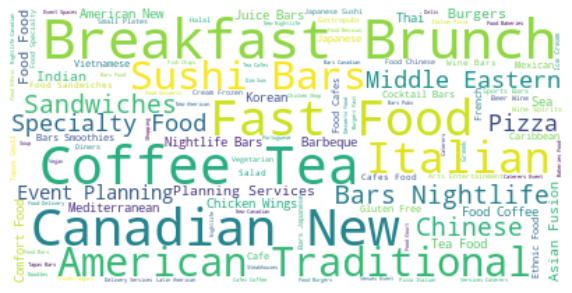

In [27]:
#most popular type of restaurants in Toronto
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# eliminate useless words
text = text.replace('Restaurants', "")
text = text.replace('bars', "")
text = text.replace('food', "")


# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
#Before starting the modelling process, we must convert 
#all columns that will be used in the model to integer. This is compulsory for the ALS model from PySpark
#ie business id and userid using stringIndexer

indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['business_id', 'user_id']]
pipeline = Pipeline(stages=indexer)
transformed = pipeline.fit(df_review).transform(df_review)
transformed.select(['business_id', 'user_id','business_id_index', 'user_id_index'])

DataFrame[business_id: string, user_id: string, business_id_index: double, user_id_index: double]

In [29]:
#dividing the model into training and testing

(training, test) = transformed.randomSplit([0.8, 0.2])

In [30]:
#creating a model for training using als

als=ALS(maxIter=5,
        regParam=0.09,
        rank=25,
        userCol="user_id_index",
        itemCol="business_id_index",
        ratingCol="stars",
        coldStartStrategy="drop",
        nonnegative=True)

model=als.fit(training)

In [31]:
#calculating the rmse value
evaluator=RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")
predictions=model.transform(test)
rmse=evaluator.evaluate(predictions)
print("RMSE="+str(rmse))

RMSE=1.3625328639913896


In [32]:
RMSE=1.3651734482322269

In [33]:
#creating a test model for testing

test = model.recommendForAllUsers(20).filter(col('user_id_index')==30).select("recommendations").collect()
topRestaurants = []
for item in test[0][0]:        
    topRestaurants.append(item.business_id_index)
    
schema = StructType([StructField("business_id_index",IntegerType(),True)])
restaurants = spark.createDataFrame(topRestaurants,IntegerType()).toDF("business_id_index")

In [39]:
dataTrans=transformed\
.select(['business_id', 'user_id', 'stars', 'categories'])\
.filter(col('user_id_index')==30)

In [43]:
dataTrans.show()

+--------------------+--------------------+-----+--------------------+
|         business_id|             user_id|stars|          categories|
+--------------------+--------------------+-----+--------------------+
|9XLH_grfIYKR7d5ZT...|i6V3NyTdkBVwPpH7r...|  2.0|Restaurants, Ital...|
|A7waf6G3cvnLfAqKe...|i6V3NyTdkBVwPpH7r...|  2.0|Restaurants, Italian|
|kuJRRmmmDUXqwM6kN...|i6V3NyTdkBVwPpH7r...|  4.0|Nightlife, Food, ...|
|aEnoF_79jQE83s-I7...|i6V3NyTdkBVwPpH7r...|  3.0|Food, Restaurants...|
|d4bVdEDwxmyB0M-w5...|i6V3NyTdkBVwPpH7r...|  4.0|Breakfast & Brunc...|
|28adZ4lsuUeVB2aWz...|i6V3NyTdkBVwPpH7r...|  5.0|Bars, Food, Gastr...|
|cTbFJzHQzFSX-z3JF...|i6V3NyTdkBVwPpH7r...|  4.0|Restaurants, Amer...|
|eQCYur0033RkZdh5V...|i6V3NyTdkBVwPpH7r...|  3.0|Italian, Breakfas...|
|Ycp3Agr7dt71TZkeK...|i6V3NyTdkBVwPpH7r...|  3.0|French, Breakfast...|
|7HrCELR6uv2HkgL7a...|i6V3NyTdkBVwPpH7r...|  2.0|Restaurants, Seaf...|
|sHXIiGercy22UVpwM...|i6V3NyTdkBVwPpH7r...|  4.0|Comfort Food, Nig...|
|nDn2h

In [35]:
restaurants\
.join(transformed, on = 'business_id_index', how = 'inner')\
.select(['business_id', 'stars', 'categories', 'name'])\
.drop_duplicates(subset=['name'])\
.show()

+--------------------+-----+--------------------+--------------------+
|         business_id|stars|          categories|                name|
+--------------------+-----+--------------------+--------------------+
|TiQBE6BdjSg9MF3UC...|  5.0|Indian, Sri Lanka...|         New Kalyani|
|bumAFxitMRHKAxZMi...|  5.0|Event Planning & ...|    Cuisine of India|
|WRJOwG8VCuG2wxw5w...|  5.0|Chicken Shop, Por...|Paulo Sardinha BB...|
|OYQcsDot2LANZhOGY...|  5.0|Breakfast & Brunc...|        Grass hopper|
|5TaPg1Pakpaesn6Rt...|  3.0|Restaurants, Sand...|              Subway|
|NPXFPL46H8aO7f9jQ...|  5.0|Restaurants, Indi...|              Thindi|
|L6bltHzP0PsZSEHDJ...|  5.0|  Greek, Restaurants|        Greek Street|
|1Qv_c1bCllShH1Qrb...|  5.0|Restaurants, Food...| Narin Deli & Pastry|
|EuGjOxz-yFTfBXJwZ...|  5.0|Desserts, Special...|Sarajevo Grill & ...|
|eohcbvMCGegrUCDnj...|  5.0|Thai, Restaurants...|     Qinthai Cuisine|
|ebYONOzrccwssIuAb...|  5.0| French, Restaurants|          Pain Perdu|
|6NrvG

In [46]:
restaurants\
.join(transformed, on = 'business_id_index', how = 'inner')\
.select(['business_id', 'stars', 'user_id', 'name','categories'])\
.drop_duplicates(subset=['name'])\
.show()

+--------------------+-----+--------------------+--------------------+--------------------+
|         business_id|stars|             user_id|                name|          categories|
+--------------------+-----+--------------------+--------------------+--------------------+
|TiQBE6BdjSg9MF3UC...|  5.0|UUijqszk8B8bLj9Y1...|         New Kalyani|Indian, Sri Lanka...|
|bumAFxitMRHKAxZMi...|  5.0|qLq9eedYCLaXjcy2X...|    Cuisine of India|Event Planning & ...|
|WRJOwG8VCuG2wxw5w...|  5.0|dEX-kJ6HUw0SpTQiJ...|Paulo Sardinha BB...|Chicken Shop, Por...|
|OYQcsDot2LANZhOGY...|  5.0|kc3EUFc_4Rjly9GWu...|        Grass hopper|Breakfast & Brunc...|
|5TaPg1Pakpaesn6Rt...|  3.0|W6CrBiuPNADGDIH_m...|              Subway|Restaurants, Sand...|
|NPXFPL46H8aO7f9jQ...|  5.0|P8WKdwdpRZ4F1SMTL...|              Thindi|Restaurants, Indi...|
|L6bltHzP0PsZSEHDJ...|  5.0|TtbKBYsve6D6hLtxN...|        Greek Street|  Greek, Restaurants|
|1Qv_c1bCllShH1Qrb...|  5.0|t8MLIkNHS0xJDtvX-...| Narin Deli & Pastry|Restaurant